### Imports

In [1]:
import re
import zlib

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scipy.stats as stats
import stumpy
from pyts.classification import LearningShapelets
from sklearn.cluster import DBSCAN, KMeans
from sklearn.metrics import pairwise_distances
from tslearn.clustering import KShape, TimeSeriesKMeans
from tslearn.generators import random_walks
from tslearn.piecewise import PiecewiseAggregateApproximation
from tslearn.preprocessing import (TimeSeriesScalerMeanVariance,
                                   TimeSeriesScalerMinMax)

# 1. Prepare Time Series Dataset

In [2]:
dataset = pd.read_csv("data/final_dataset.csv")
print("Shape of dataset:", dataset.shape)
dataset.head()

Shape of dataset: (239381, 77)


,date,year,city_or_county,latitude,longitude,min_age_participants,avg_age_participants,max_age_participants,teen_ratio,adults_ratio,...,state_Texas,state_Utah,state_Vermont,state_Virginia,state_Washington,state_West Virginia,state_Wisconsin,state_Wyoming,month_x,month_y
0,729.0,2015.0,Indianapolis,39.8322,-86.2492,19.0,19.0,19.0,0.0,1.0,...,False,False,False,False,False,False,False,False,5.000000e-01,-0.866025
1,1459.0,2017.0,Kane,41.6645,-78.7856,62.0,62.0,62.0,0.0,1.0,...,False,False,False,False,False,False,False,False,8.660254e-01,-0.500000
2,1404.0,2016.0,Detroit,42.4190,-83.0393,19.0,19.0,19.0,0.0,1.0,...,False,False,False,False,False,False,False,False,-5.000000e-01,0.866025
3,1383.0,2016.0,Washington,38.9030,-76.9820,21.0,21.0,21.0,0.0,1.0,...,False,False,False,False,False,False,False,False,-8.660254e-01,0.500000
4,894.0,2015.0,Pittsburgh,40.4621,-80.0308,21.0,21.0,21.0,0.0,1.0,...,False,False,False,False,False,False,False,False,1.224647e-16,-1.000000


## 1.1 Select cities

In [3]:
dataset['year'].value_counts()

year
2017.0    61389
2016.0    58724
2015.0    53335
2014.0    51684
2018.0    13801
2013.0      448
Name: count, dtype: int64

Keep only incidents regarding [2014, 2015, 2016, 2017], as by project assignment instructions.

In [4]:
dataset = dataset[(dataset['year'] > 2013) & (dataset['year'] < 2018)]

Analysis of cities reveals that many cities are present with different names, resulting in incorrect city value counts.

In [5]:
with open('debugging/cities.txt', 'w') as f:
    for item in dataset['city_or_county'].unique():
        f.write("%s\n" % item)
        
# Write city and value counts of each city to a file
with open('debugging/city_counts.txt', 'w') as f:
    f.write(dataset['city_or_county'].value_counts().to_string())

print('There are {} unique cities in the dataset'.format(len(dataset['city_or_county'].unique())))
        

There are 12596 unique cities in the dataset


Eliminate parenthesis with county or extra information.

In [6]:
# Eliminate all data between parenthesis in the city column using re module
dataset['city_or_county'] = dataset['city_or_county'].apply(lambda x: re.sub(r"\(.*\)", "", x))
print('There are {} unique cities in the dataset'.format(len(dataset['city_or_county'].unique())))

There are 11762 unique cities in the dataset


Sort cities alphabetically to see if there are still duplicates and how relevant they are.

In [7]:
# Get all cities and sort them alphabetically and write them in a file
cities = dataset['city_or_county'].unique()
cities.sort()
with open('debugging/cities2.txt', 'w') as f:
    for item in cities:
        f.write("%s\n" % item)

We can see that there are many cities which differ in having a space in the end, let's remove all spaces to avoid problems.

In [8]:
# Remove all spaces from city names
dataset['city_or_county'] = dataset['city_or_county'].apply(lambda x: x.replace(" ", ""))
print('There are {} unique cities in the dataset'.format(len(dataset['city_or_county'].unique())))

There are 10416 unique cities in the dataset


In [9]:
dataset['city_or_county'] = dataset['city_or_county'].str.upper()
print('There are {} unique cities in the dataset'.format(len(dataset['city_or_county'].unique())))

There are 10331 unique cities in the dataset


Introducing a week parameter and filtering only cities with a number of weeks with incidents greater than 15% of the total number of the weeks of the 4 years.

In [10]:
dataset['week'] = " "

# Date attribute is a progressive integer number, starting from 0
# Assign a week number to each date
dataset['date'] = dataset['date'] - dataset['date'].min()
dataset['week'] = dataset['date'].apply(lambda x: int(x / 7))

n_weeks = dataset['week'].max()
n_weeks

208

In [11]:
cities = dataset['city_or_county'].unique()
dropping_threshold = 0.15

for city in cities:
    city_data = dataset[dataset['city_or_county'] == city]
    city_weeks_with_incidents = city_data['week'].nunique()

    # Drop the city if it has less than 15% of the weeks with incidents
    if city_weeks_with_incidents < n_weeks * dropping_threshold:
        dataset = dataset[dataset['city_or_county'] != city]

print('Number of cities for which time series will be generated:', dataset['city_or_county'].nunique())
dataset.head()

Number of cities for which time series will be generated: 713


,date,year,city_or_county,latitude,longitude,min_age_participants,avg_age_participants,max_age_participants,teen_ratio,adults_ratio,...,state_Utah,state_Vermont,state_Virginia,state_Washington,state_West Virginia,state_Wisconsin,state_Wyoming,month_x,month_y,week
0,364.0,2015.0,INDIANAPOLIS,39.8322,-86.2492,19.0,19.0,19.0,0.0,1.0,...,False,False,False,False,False,False,False,5.000000e-01,-8.660254e-01,52
2,1039.0,2016.0,DETROIT,42.4190,-83.0393,19.0,19.0,19.0,0.0,1.0,...,False,False,False,False,False,False,False,-5.000000e-01,8.660254e-01,148
3,1018.0,2016.0,WASHINGTON,38.9030,-76.9820,21.0,21.0,21.0,0.0,1.0,...,False,False,False,False,False,False,False,-8.660254e-01,5.000000e-01,145
4,529.0,2015.0,PITTSBURGH,40.4621,-80.0308,21.0,21.0,21.0,0.0,1.0,...,False,False,False,False,False,False,False,1.224647e-16,-1.000000e+00,75
7,805.0,2016.0,NEWHAVEN,41.2945,-72.9457,20.0,20.0,20.0,1.0,0.0,...,False,False,False,False,False,False,False,1.000000e+00,6.123234e-17,115


In [12]:
# Save dataset in csv
dataset.to_csv('debugging/ts.csv', index=False)

## 1.3 Generation with different score functions for each subtask

Define the functions to compute the score for each of the two subtasks

In [13]:
def compute_week_score(week_data, task):
    # Compute the score for a given week, to be used in the time series
    if task == 'task1':
        score = (week_data['killed_ratio'] * week_data['n_participants']).sum()
    elif task == 'shapelet_learning':
        score = (week_data['killed_ratio'] * week_data['n_participants']).sum()
    return score

def generate_time_series(city_data, n_weeks, task):
    """Generate the time series for a given city

    Args:
        city_data (pandas.DataFrame): Data for a given city
        n_weeks (int): Number of weeks in the dataset
        task (str): Task to be performed

    Returns:
        numpy.ndarray: Time series for the given city
            Shape (n_weeks, ) if task is 'task1'    
            Shape (n_weeks, 2) if task is 'shapelet_learning'
    """
    # Generate the time series for a given city
    time_series = np.zeros(n_weeks)
    for week in range(n_weeks):
        week_data = city_data[city_data['week'] == week]
        if week_data.shape[0] > 0:
            time_series[week] = compute_week_score(week_data, task)

    return time_series

def generate_time_series_with_label(city_data, n_weeks, task):
    """Generate the time series for a given city.
    Label is referred to the whole time series.

    Args:
        city_data (pandas.DataFrame): Data for a given city
        n_weeks (int): Number of weeks in the dataset
        task (str): Task to be performed

    Returns:
        numpy.ndarray: Time series for the given city
            Shape (n_weeks, )
        int: Label for the time series
    """
    # Generate the time series for a given city
    time_series = np.zeros(n_weeks)
    for week in range(n_weeks):
        week_data = city_data[city_data['week'] == week]
        if week_data.shape[0] > 0:
            time_series[week] = compute_week_score(week_data, 'shapelet_learning')
    
    if city_data['killed_ratio'].sum() > 0:
        label = 1
    else:
        label = 0

    return time_series, label

def generate_time_series_dataset(dataset, task, scaling = None):
    """Generate the time series dataset

    Args:
        dataset (pandas.DataFrame): Dataset
        task (str): Task to be performed
        scaling (str, optional): Scaling method to be used. Defaults to None.

    Returns:
        if task is 'task1':
            numpy.ndarray: Time series dataset
        elif task is 'shapelet_learning':
            list: [Time series dataset, labels]
        
        numpy.ndarray: Cities of the time series dataset
    """
    # Generate the time series for all cities
    n_weeks = dataset['week'].max()
    cities = dataset['city_or_county'].unique()
    time_series = []
    labels = []
    for city in cities:
        city_data = dataset[dataset['city_or_county'] == city]

        if task == 'shapelet_learning':
            ts, label = generate_time_series_with_label(city_data, n_weeks, task)
            time_series.append(ts)
            labels.append(label)
        else:
            time_series.append(generate_time_series(city_data, n_weeks, task))
        
    time_series = np.array(time_series)
    labels = np.array(labels)

    # Scale the time series
    if scaling == 'minmax':
        time_series = TimeSeriesScalerMinMax().fit_transform(time_series)
    elif scaling == 'zscore':
        time_series = TimeSeriesScalerMeanVariance().fit_transform(time_series)
    elif scaling == 'none':
        # Add the dimensionality as the scalers do for consistency
        time_series = time_series.reshape(time_series.shape[0], time_series.shape[1], 1)

    if task == 'shapelet_learning':
        # Add the labels to the time series, adjusting the shape of labels 
        time_series = [time_series, labels]

    return time_series, cities

In our case, no resampling is necessary as all sequences are of same length, as we define them over 208 weeks. Furthermore, no approximation is needed as the resulting dataset of time series is small.

# 2. Clustering

## 2.1 Generate time series

In [14]:
ts_dataset, cities = generate_time_series_dataset(dataset, task = 'task1', scaling = 'minmax')
ts_dataset.shape

Generated time series for city INDIANAPOLIS
Generated time series for city DETROIT
Generated time series for city WASHINGTON
Generated time series for city PITTSBURGH
Generated time series for city NEWHAVEN
Generated time series for city STAFFORD
Generated time series for city TULSA
Generated time series for city BRONX
Generated time series for city KANSASCITY
Generated time series for city LONGVIEW
Generated time series for city ASHEVILLE
Generated time series for city LAREDO
Generated time series for city PHILADELPHIA
Generated time series for city LOSANGELES
Generated time series for city CHICAGO
Generated time series for city SEATTLE
Generated time series for city NEWORLEANS
Generated time series for city JACKSONVILLE
Generated time series for city DECATUR
Generated time series for city BOSTON
Generated time series for city MURFREESBORO
Generated time series for city HUNTINGTON
Generated time series for city BROOKLYN
Generated time series for city ROCKFORD
Generated time series for

(713, 208, 1)

In [15]:
print(cities)

['INDIANAPOLIS' 'DETROIT' 'WASHINGTON' 'PITTSBURGH' 'NEWHAVEN' 'STAFFORD'
 'TULSA' 'BRONX' 'KANSASCITY' 'LONGVIEW' 'ASHEVILLE' 'LAREDO'
 'PHILADELPHIA' 'LOSANGELES' 'CHICAGO' 'SEATTLE' 'NEWORLEANS'
 'JACKSONVILLE' 'DECATUR' 'BOSTON' 'MURFREESBORO' 'HUNTINGTON' 'BROOKLYN'
 'ROCKFORD' 'LITTLEROCK' 'BROCKTON' 'CHATTANOOGA' 'VIRGINIABEACH'
 'ATLANTICCITY' 'OAKLAND' 'SANJOSE' 'TOLEDO' 'BRIDGEPORT' 'MOUNTVERNON'
 'QUEENS' 'FULTON' 'SYRACUSE' 'SANANGELO' 'COLUMBUS' 'FLINT' 'HOUMA'
 'TROY' 'ORANGE' 'NORTHLASVEGAS' 'DAYTON' 'YOUNGSTOWN' 'SAINTLOUIS'
 'TERREHAUTE' 'RICHMOND' 'GRANDJUNCTION' 'FORTWAYNE' 'WARREN' 'JACKSON'
 'AUGUSTA' 'ALBUQUERQUE' 'LONGBEACH' 'CHARLOTTESVILLE' 'PORTLAND'
 'BIRMINGHAM' 'FRESNO' 'TUCSON' 'BALTIMORE' 'LASVEGAS' 'ANNAPOLIS'
 'COMPTON' 'DULUTH' 'MILWAUKEE' 'CINCINNATI' 'WATERTOWN' 'HAMPTON'
 'TUPELO' 'SAVANNAH' 'YORK' 'NEWBEDFORD' 'KANKAKEE' 'CHAMPAIGN' 'WICHITA'
 'NORFOLK' 'NEWBURGH' 'CAPEGIRARDEAU' 'HOUSTON' 'AURORA' 'PEORIA'
 'WILLIAMSBURG' 'UTICA' 'NEWARK' 'FREEPOR

In [16]:
X = ts_dataset

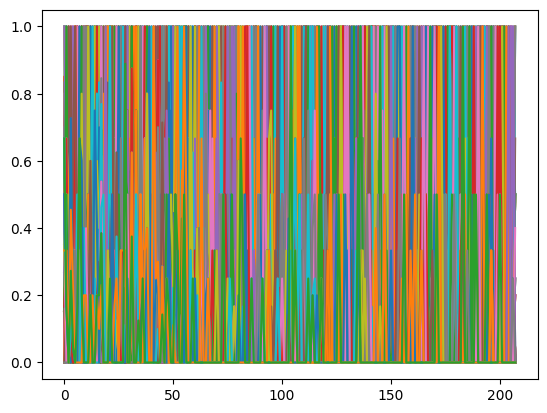

In [17]:
plt.plot(X.reshape(X.shape[1], X.shape[0]))
plt.show()

## 2.2 Shape-based Clustering 

### 2.2.1 KMeans with Euclidean Distance

In [18]:
km = TimeSeriesKMeans(n_clusters=5, metric="euclidean", max_iter=10, random_state=0)
km.fit(X)

TimeSeriesKMeans(max_iter=10, n_clusters=5, random_state=0)

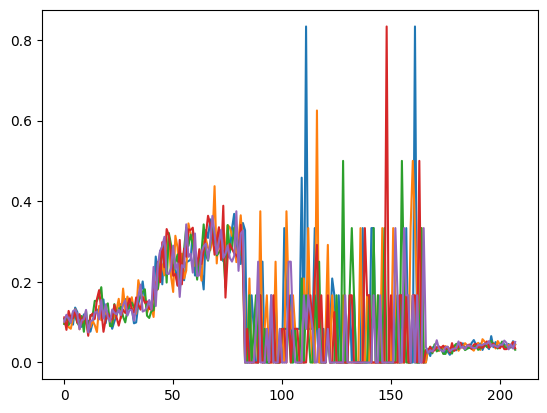

In [19]:
plt.plot(km.cluster_centers_.reshape(X.shape[1], 5))
plt.show()

### 2.2.1 KMeans with DTW

In [20]:
km_dtw = TimeSeriesKMeans(n_clusters=5, metric="dtw", max_iter=5, random_state=0)
km_dtw.fit(X)

TimeSeriesKMeans(max_iter=5, metric='dtw', n_clusters=5, random_state=0)

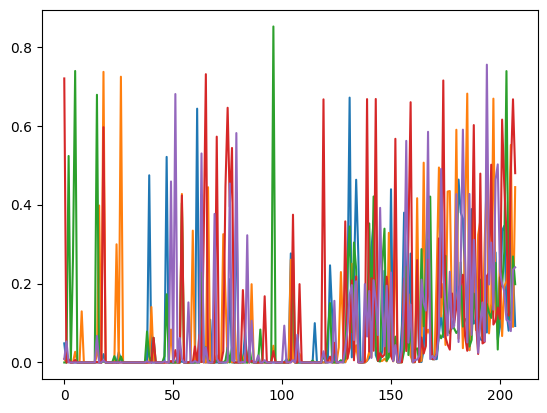

In [21]:
plt.plot(km_dtw.cluster_centers_.reshape(X.shape[1], 5))
plt.show()

### 2.2.1 KShape

In [22]:
ks = KShape(n_clusters=5, n_init=1, random_state=0).fit(X)
ks.cluster_centers_.shape

(5, 208, 1)

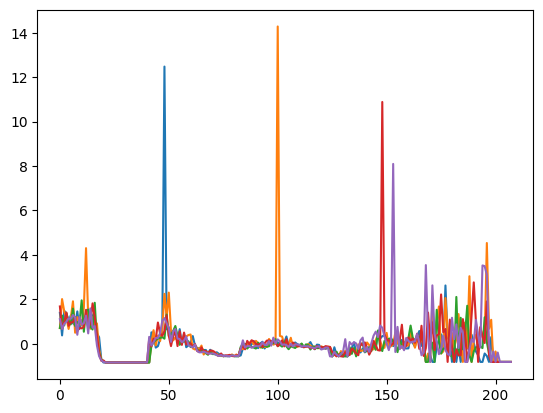

In [23]:
plt.plot(ks.cluster_centers_.reshape(X.shape[1], 5))
plt.show()

In [24]:
# Inertia of the three algorithms
print("Inertia of the three algorithms:")
print("Euclidean k-means:", km.inertia_)
print("DTW k-means:", km_dtw.inertia_)
print("k-Shape:", ks.inertia_)

Inertia of the three algorithms:
Euclidean k-means: 5.051855769843218
DTW k-means: 1.3498022259309186
k-Shape: 0.27099322799712566


## 2.3 Feature-based Clustering

In [25]:
def calculate_features(values):
    features = {
        'avg': np.mean(values),
        'std': np.std(values),
        'var': np.var(values),
        'med': np.median(values),
        '10p': np.percentile(values, 10),
        '25p': np.percentile(values, 25),
        '50p': np.percentile(values, 50),
        '75p': np.percentile(values, 75),
        '90p': np.percentile(values, 90),
        'iqr': np.percentile(values, 75) - np.percentile(values, 25),
        'cov': 1.0 * np.mean(values) / np.std(values),
        'skw': stats.skew(values),
        'kur': stats.kurtosis(values)
    }

    return features

In [26]:
F = [list(calculate_features(x).values())[:-2] for x in X]

In [27]:
kmeans = KMeans(n_clusters=5, n_init=10)
kmeans.fit(F)

KMeans(n_clusters=5, n_init=10)

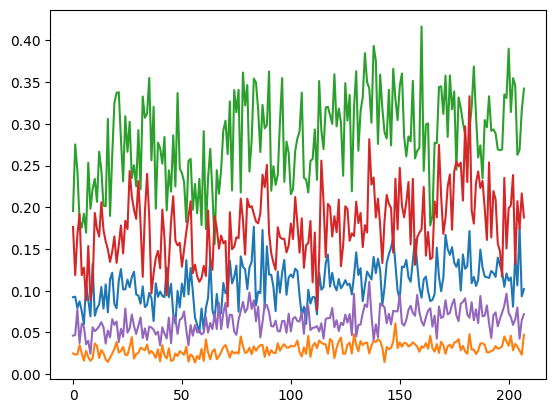

In [28]:
for i in range(5):
    plt.plot(np.mean(X[np.where(kmeans.labels_ == i)[0]], axis=0))
plt.show()

In [29]:
kmeans.inertia_

11.158413967626432

## 2.4 Compression-based clustering

In [30]:
def cdm_dist(x, y):
    x_str = (' '.join([str(v) for v in x.ravel()])).encode('utf-8')
    y_str = (' '.join([str(v) for v in y.ravel()])).encode('utf-8')
    return len(zlib.compress(x_str + y_str)) / (len(zlib.compress(x_str)) + len(zlib.compress(y_str)))

In [31]:
M = pairwise_distances(X.reshape(X.shape[0], X.shape[1]), metric=cdm_dist)

In [32]:
dbscan = DBSCAN(eps=0.965, min_samples=5, metric='precomputed')
dbscan.fit(M)

DBSCAN(eps=0.965, metric='precomputed')

## 2.5 Approximation-based clustering

In [33]:
n_paa_segments = 10
paa = PiecewiseAggregateApproximation(n_segments=n_paa_segments)
X_paa = paa.fit_transform(X)

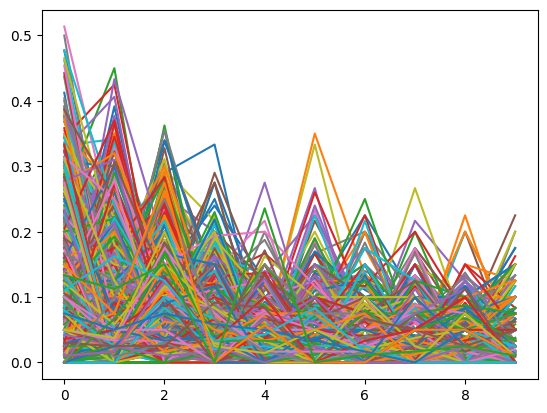

In [34]:
plt.plot(X_paa.reshape(X_paa.shape[1], X_paa.shape[0]))
plt.show()

In [35]:
km = TimeSeriesKMeans(n_clusters=3, metric="euclidean", max_iter=5, random_state=0)
km.fit(X_paa)

TimeSeriesKMeans(max_iter=5, random_state=0)

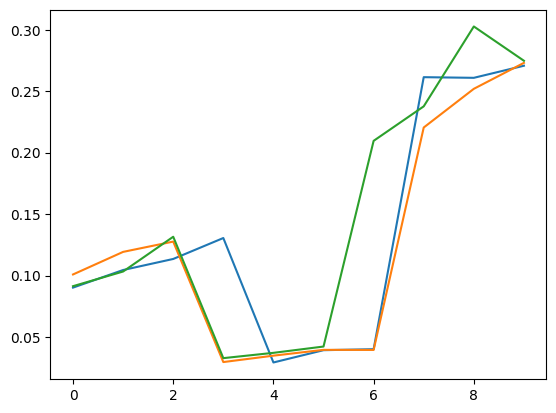

In [36]:
plt.plot(km.cluster_centers_.reshape(X_paa.shape[1], 3))
plt.show()

Recompute the centroid from time series in cluster.

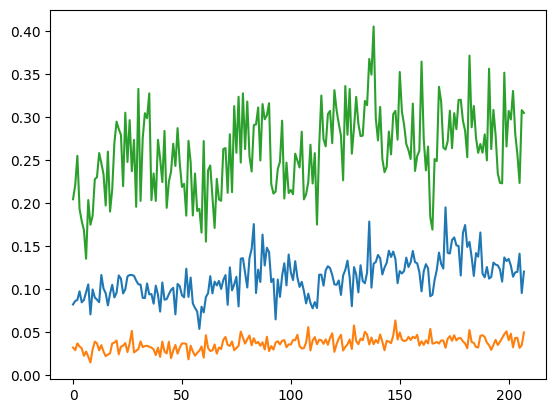

In [37]:
for i in range(3):
    plt.plot(np.mean(X[np.where(km.labels_ == i)[0]], axis=0))
plt.show()

# 3. Motif Extraction

In [38]:
# Stumpy library calculates the matrix profile for a given time series
# Select the city with most weeks with incidents in the dataset and calculate its matrix profile
non_zero_values = np.count_nonzero(X, axis=1)
city_index = np.argmax(non_zero_values)
city = cities[city_index]

ts = X[city_index]  
print('City with most weeks with incidents:', city)
print('Number of weeks with incidents:', non_zero_values[city_index])
ts = ts.reshape(ts.shape[0])
ts.shape

City with most weeks with incidents: CHICAGO
Number of weeks with incidents: [207]


(208,)

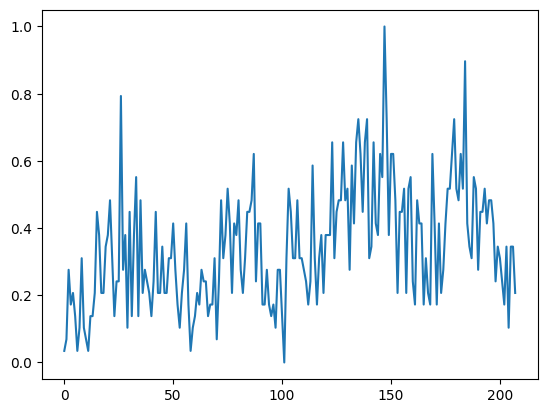

In [39]:
# Plot the time series

plt.plot(ts)

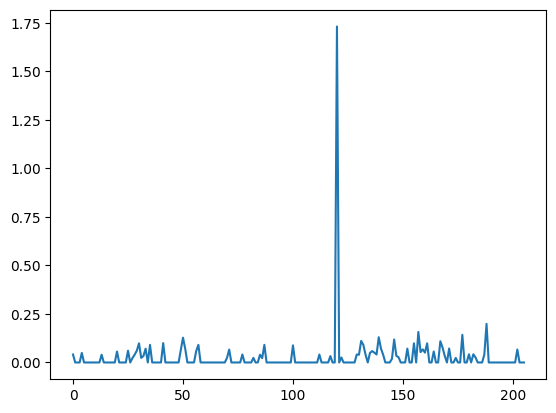

In [41]:
w = 10
mp = stumpy.stump(ts, w)[:, 0]

plt.plot(mp)
plt.show()

In [42]:
# Find the motifs and their locations
motif_dist, motif_idx = stumpy.motifs(ts, mp, max_motifs=5)

/Users/dre/Desktop/GitRepo/Others/DataMiningProject/venv/lib/python3.9/site-packages/stumpy/motifs.py:340: UserWarning: The `cutoff` has been set to 0.0 and may result in little/no candidate motifs being identified.
You may consider relaxing the constraint by increasing the `cutoff` (e.g., cutoff=0.0).
  warnings.warn(msg)


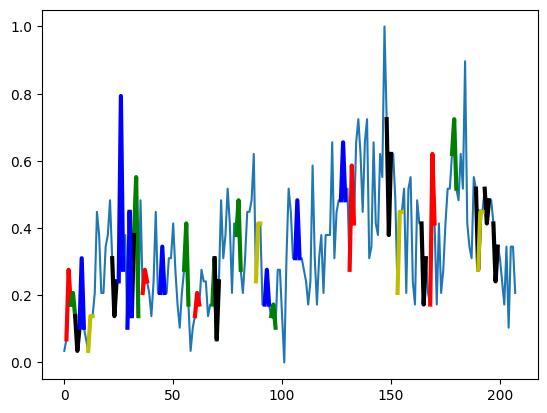

In [43]:
plt.plot(ts)

colors = ['r', 'g', 'k', 'b', 'y'][:len(motif_dist)]

for motifs, indices, color in zip(motif_dist, motif_idx, colors):
    for index in indices:
        motif_shape = ts[index:index + w]
        if len(motif_shape) == w:
            plt.plot(range(index, index + w), motif_shape, color=color, lw=3)

plt.show()

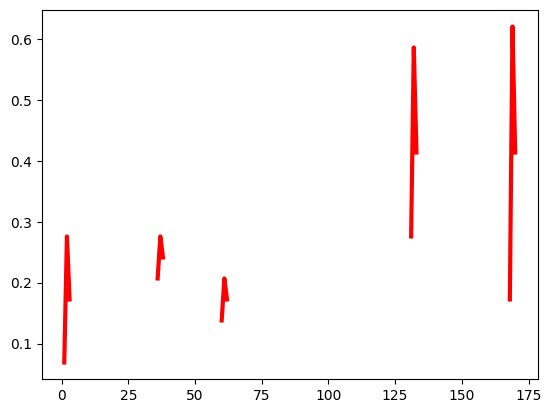

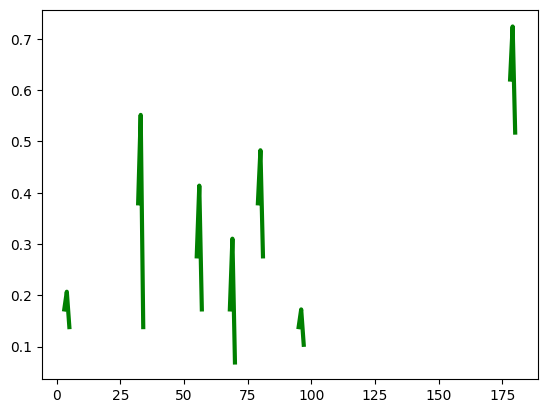

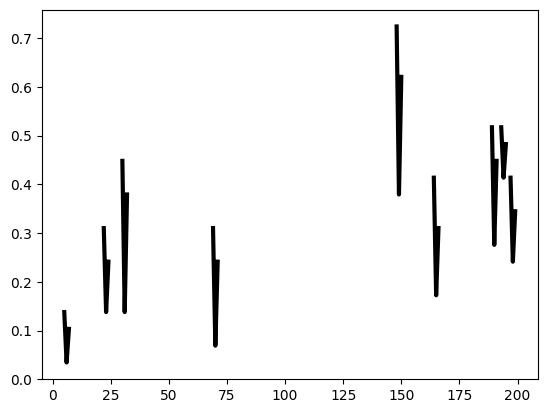

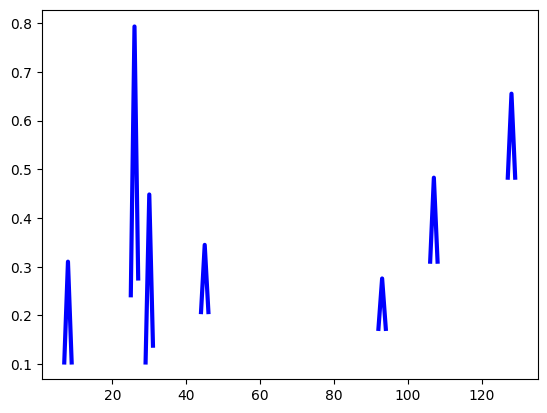

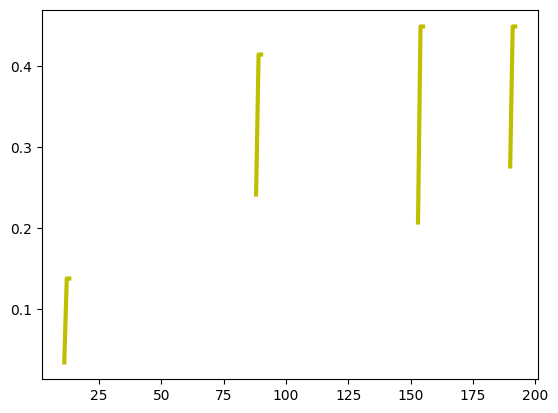

In [44]:
for motifs, indices, color in zip(motif_dist, motif_idx, colors):
    for index in indices:
        motif_shape = ts[index:index + w]
        if len(motif_shape) == w:
            plt.plot(range(index, index + w), motif_shape, color=color, lw=3)
    plt.show()

# 4. Anomaly Detection

Calculate anomalies as out of distribution values of the matrix profile.

In [45]:
# Calculate z-scores for the matrix profile
z_scores = stats.zscore(mp.tolist())

# Define a threshold (e.g., 3 standard deviations)
threshold = 3

# Find anomalies based on the threshold
anomalies = np.where(np.abs(z_scores) > threshold)[0]

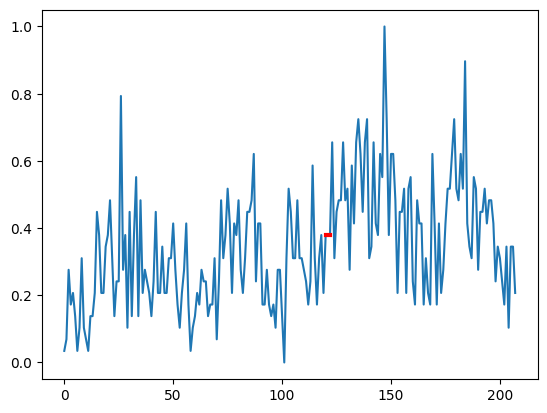

In [46]:
plt.plot(ts)
for a in anomalies:
    a_shape = ts[a:a+w]
    plt.plot(range(a, a+w), a_shape, color='r', lw=3)

plt.show()

# 5. Shapelet Extraction

In [62]:
from tslearn.shapelets import LearningShapelets, grabocka_params_to_shapelet_size_dict
from sklearn.model_selection import train_test_split
import tensorflow as tf

## 5.1 Dataset preparation with labelling

In [55]:
ts_dataset, cities = generate_time_series_dataset(dataset, task = 'shapelet_learning', scaling = 'minmax')

X = ts_dataset[0]
y = ts_dataset[1]


Generated time series for city INDIANAPOLIS
Generated time series for city DETROIT
Generated time series for city WASHINGTON
Generated time series for city PITTSBURGH
Generated time series for city NEWHAVEN
Generated time series for city STAFFORD
Generated time series for city TULSA
Generated time series for city BRONX
Generated time series for city KANSASCITY
Generated time series for city LONGVIEW
Generated time series for city ASHEVILLE
Generated time series for city LAREDO
Generated time series for city PHILADELPHIA
Generated time series for city LOSANGELES
Generated time series for city CHICAGO
Generated time series for city SEATTLE
Generated time series for city NEWORLEANS
Generated time series for city JACKSONVILLE
Generated time series for city DECATUR
Generated time series for city BOSTON
Generated time series for city MURFREESBORO
Generated time series for city HUNTINGTON
Generated time series for city BROOKLYN
Generated time series for city ROCKFORD
Generated time series for

In [63]:
# See how many time series in dataset have at least one killing and how many don't
# This is the label for the shapelet learning task
print('Number of time series with at least one killing:', np.sum(y))
print('Number of time series with no killings:', y.shape[0] - np.sum(y))

Number of time series with at least one killing: 713
Number of time series with no killings: 0


In [64]:
# Split into train, validation and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, stratify=y_train)

## 5.2 Shapelet Discovery

Define the hyperparameters.

In [65]:
# Define hyperparams
n_ts, ts_sz = X_train.shape[:2]
l = 0.05
r = 4

In [66]:
# Follow github repo https://github.com/stephanielees/shapeletsLTS-humansensor/blob/main/shapelet-tslearn.ipynb
PERCENTAGE = 0.1
# Select randomly 10% of the time series in the training set to extract shapelets from
indexes = np.random.choice(X_train.shape[0], int(X_train.shape[0] * PERCENTAGE), replace=False)
X_train_small = X_train[indexes]
y_train_small = y_train[indexes]

In [67]:
shapelet_dict = grabocka_params_to_shapelet_size_dict(n_ts = n_ts, ts_sz = ts_sz, n_classes = 2, l = l, r = r)
shapelet_dict

{10: 4, 20: 4, 30: 4, 40: 4}

Generate shapelets on the small training set and then use those shapelets for doing the shapelet transform on all setes: the full training set, the validation set and the test set. We will then use these resulting shapelet-transformed sets to train the classifier.

In [68]:
trans = LearningShapelets(weight_regularizer=0.001, batch_size=512, max_iter=2500, total_lengths=5,
                          optimizer=tf.keras.optimizers.Adam(learning_rate=0.003), scale=False)

# Fit the model
trans.fit(X_train_small, y_train_small)
shapelets_learned = trans.shapelets_
shapelets_learned_as_ts = trans.shapelets_as_time_series

train_shapelets = trans.transform(X_train)
valid_shapelets = trans.transform(X_val)
test_shapelets = trans.transform(X_test)

print(train_shapelets.shape)
print(valid_shapelets.shape)
print(test_shapelets.shape)
print('Number of shapelets according to the shapelet dictionary:', sum(shapelet_dict.values()))
print('Actual number of shapelets learned:', shapelets_learned.shape[0])


ValueError: Classifier can't train when only one class is present.

In [ ]:
# Show the shapelets that are as many as we calculated in the dictionary
for shapelet_len, n_shapelets in shapelet_dict.items():  
    plt.figure(figsize=(8,5))
    for j in range(n_shapelets):
        plt.plot(shapelets_learned_as_ts[shapelet_len][j], label='Shapelet length {}'.format(shapelet_len))
    plt.legend()
    plt.show()

NameError: name 'shp_clf' is not defined

As explained in the paper, multiple similar shapelets is not necessarily a bad thing. In ML, generally, having two similar features might cause multicollinearity and bias, but in the case of shapelets, one shapelet might not be able to separate the data, so multiple similar shapelets may be actually useful.

Paper: https://www.ismll.uni-hildesheim.de/pub/pdfs/grabocka2014e-kdd.pdf

## 5.3 Classification with Shapelets

In [ ]:
import lightgbm as lgbm

In [ ]:
model = lgbm.LGBMClassifier(n_estimators = 3500, random_state=8)
model.fit(train_shapelets, y_train, eval_set=[(valid_shapelets, y_val)], eval_metric='accuracy')

NameError: name 'shapelet_sizes' is not defined

<Figure size 640x480 with 0 Axes>

### 5.3.1 Model evaluation

In [ ]:
# Evaluate the accuracy of the model on the test set
y_pred = model.predict(test_shapelets)
accuracy = np.sum(y_pred == y_test) / len(y_test)
print('Accuracy on the test set:', accuracy)